In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

I'm borrowing the template code from class. The source code can be found here: https://www.physics.rutgers.edu/grad/509/Wang%20Landau.html

In [2]:
@njit
def CEnergy(latt):
    "Energy of configuration for the 2D Ising model"
    N = np.shape(latt)[0]
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]   # Spin, can be either +1 or -1
            WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
            Ene += -S * WF
    return Ene/2.

def RandomL(N):
    "Random lattice corresponding to infinite temperature"
    return np.array(np.sign(2*np.random.random((N,N))-1),dtype=int) 

In [3]:
def PrepareEnergies(N):
    Energies = (np.array(4*np.arange(-int(N*N/2),int(N*N/2)+1),dtype=int)).tolist() # -2 N^2...2N^2 in steps of 4
    #Energies = range(-2*N*N,2*N*N,4)
    Energies.pop(1)  # take out E[1]
    Energies.pop(-2) # take out E[-2]
    Energies = np.array(Energies) # make array of energies again
    Emin, Emax = Energies[0],Energies[-1]
    #index array to energies
    indE = -np.ones(Emax+1-Emin, dtype=int) # index table to get index to particular energy g(E)~g[indE[E]]
    for i,E in enumerate(Energies):
        indE[E-Emin]=i
    # Ising lattice at infinite T
    ## g(E) we know E = -2*N^2,2*N^2 in steps of 4...
    return (Energies, indE, Emin)

In [4]:
Ene,indE,Emin = PrepareEnergies(10)
print('Emin=',Emin)
print(Ene)
print(indE)

Emin= -200
[-200 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144
 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100  -96  -92  -88
  -84  -80  -76  -72  -68  -64  -60  -56  -52  -48  -44  -40  -36  -32
  -28  -24  -20  -16  -12   -8   -4    0    4    8   12   16   20   24
   28   32   36   40   44   48   52   56   60   64   68   72   76   80
   84   88   92   96  100  104  108  112  116  120  124  128  132  136
  140  144  148  152  156  160  164  168  172  176  180  184  188  192
  200]
[ 0 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  2 -1 -1 -1  3 -1 -1 -1  4 -1 -1 -1
  5 -1 -1 -1  6 -1 -1 -1  7 -1 -1 -1  8 -1 -1 -1  9 -1 -1 -1 10 -1 -1 -1
 11 -1 -1 -1 12 -1 -1 -1 13 -1 -1 -1 14 -1 -1 -1 15 -1 -1 -1 16 -1 -1 -1
 17 -1 -1 -1 18 -1 -1 -1 19 -1 -1 -1 20 -1 -1 -1 21 -1 -1 -1 22 -1 -1 -1
 23 -1 -1 -1 24 -1 -1 -1 25 -1 -1 -1 26 -1 -1 -1 27 -1 -1 -1 28 -1 -1 -1
 29 -1 -1 -1 30 -1 -1 -1 31 -1 -1 -1 32 -1 -1 -1 33 -1 -1 -1 34 -1 -1 -1
 35 -1 -1 -1 36 -1 -1 -1 37 -1 -1 -1 38 -1 -1 -

In [5]:
@njit
def RunWangLandau(Nitt,Energies,latt,indE):
    N   = len(latt)
    Ene = int(CEnergy(latt))
    #min,maximum energy
    Emin, Emax = Energies[0],Energies[-1]
    # Logarithm of the density of states
    lngE = np.zeros(len(Energies))
    # Histogram
    Hist = np.zeros(len(Energies))
    # modification factor
    lnf = 1.0   # f = exp(lnf)=e
    N2 = N*N
    for itt in range(Nitt):
        t = int(np.random.rand()*N2)
        (i, j) = (int(t/N), t%N)
        S = latt[i,j]
        WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
        Enew = Ene + int(2*S*WF) # the energy change if we flip the spin
        # P = g(E)/g(Enew) = exp(log(g(E))-log(g(Enew)))
        # P = exp(lngE(E)-lngE(Enew))
        lgnew = lngE[indE[Enew-Emin]] # log(g(Enew))
        lgold = lngE[indE[Ene-Emin]]  # log(g(Eold))
        P = 1.0
        if lgold-lgnew < 0 : P=np.exp(lgold-lgnew) # P = g_old/g_new = exp(log(g_old)-log(g_new))
        if P > np.random.rand():
            # accept the step
            latt[i,j] = -S
            Ene = Enew
        Hist[indE[Ene-Emin]] += 1
        lngE[indE[Ene-Emin]] += lnf   # g(E) -> g(E)*f hence log(g(E)) -> log(g(E))+log(f)
        
        if (itt+1) % 1000 == 0: # checking for flatness of the histogram
            aH = sum(Hist)/N2 # average
            mH = min(Hist)
            if mH > aH*flatness:  # histogram is flat
                Hist[:] = 0
                lnf /= 2.
                print(itt, 'histogram is flat', mH, aH, 'f=', np.exp(lnf))
    return (lngE, Hist)

In [6]:
def WangLandau(Nitt, N, flatness):
    "Wang Landau in Python"
    (Energies, indE, Emin) = PrepareEnergies(N)
    latt = RandomL(N)
    return RunWangLandau(Nitt,Energies,latt,indE)

In [7]:
flatness = 0.9
N = 32
Nitt = int(10e8)

#N=10
#Nitt = int(10e6)

(lngE, Hist) = WangLandau(Nitt, N, flatness)
print('Done')

72933999 histogram is flat 64467.0 71224.609375 f= 1.6487212707001282
87120999 histogram is flat 12474.0 13854.4921875 f= 1.2840254166877414
104393999 histogram is flat 15185.0 16868.1640625 f= 1.1331484530668263
121845999 histogram is flat 15342.0 17042.96875 f= 1.0644944589178593
140065999 histogram is flat 16032.0 17792.96875 f= 1.0317434074991028
151755999 histogram is flat 10285.0 11416.015625 f= 1.0157477085866857
166512999 histogram is flat 12976.0 14411.1328125 f= 1.007843097206448
185689999 histogram is flat 16858.0 18727.5390625 f= 1.0039138893383475
204252999 histogram is flat 16323.0 18127.9296875 f= 1.0019550335910028
227952999 histogram is flat 20853.0 23144.53125 f= 1.0009770394924165
258729999 histogram is flat 27060.0 30055.6640625 f= 1.0004884004786945
310087999 histogram is flat 45158.0 50154.296875 f= 1.0002441704297478
380141999 histogram is flat 61970.0 68412.109375 f= 1.0001220777633837
468294999 histogram is flat 77501.0 86086.9140625 f= 1.0000610370189331
70065

In [8]:
lngE[0],lngE[-1]

(86198.1813659668, 86196.58374023438)

In [9]:
# Proper normalization of the Density of states
# g *= 4/(g[0]+g[-1]) = 4/(g[-1]*(1+g[0]/g[-1]))
# g = g * 4/(g[-1]*(1+g[0]/g[-1]))
# log(g) = log(g) + log(4)-log(g[-1]) - log(1+g[0]/g[-1])
# log(g) += log(4)-log(g[-1])-log(1+exp(log(g[0])-log(g[-1])))
# 
if lngE[-1]>lngE[0]:
    lgC = np.log(4)-lngE[-1]-np.log(1+np.exp(lngE[0]-lngE[-1]))
else:
    lgC = np.log(4)-lngE[0]-np.log(1+np.exp(lngE[-1]-lngE[0]))

lngE += lgC

In [10]:
np.exp(lngE[0])+np.exp(lngE[-1]), np.exp(lngE[0]), np.exp(lngE[-1])  # g[0]+g[-1]

(3.9999999999997065, 3.3267451474274186, 0.673254852572288)

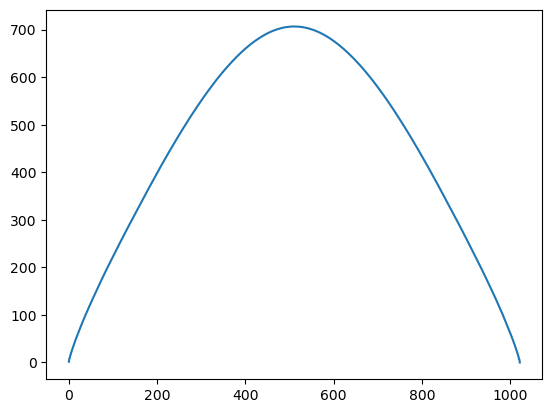

In [11]:
plt.plot(lngE)

In [12]:
(Energies, indE, Emin) = PrepareEnergies(N)

def Thermod(T, lngE, Energies, N):
    Z = 0.
    Ev = 0.  # <E>
    E2v = 0. # <E^2>
    # <E^n> = sum_E e^(-E/T)*g[E] E^n /Z
    # Zw = Z/Z_0
    # <E^n> = Z0/Z sum_E e^(-(E-Emin)/T) g[E]/g[0] E^N
    for i,E in enumerate(Energies):
        # Z += exp(log(g)) * exp(-E/T)
        # Z/Z_0 = w where Z_0 = g[0] exp(-Energies[0]/T)
        w = np.exp(lngE[i]-lngE[0]-(E-Energies[0])/T) # g(E)/g0 Exp(-(E-E0)/T)
        Z += w
        Ev += w*E
        E2v += w*E**2
    Ev *= 1./Z
    E2v *= 1./Z
    cv = (E2v-Ev**2)/T**2
    # Z_correct = Z * exp(lngE[0]-Energies[0]/T)
    # Entropy = log(Z_correct) + <E>/T = log(Z) + lngE[0]-Energies[0]/T + Ev/T
    Entropy = np.log(Z)+lngE[0]+Ev/T-Energies[0]/T
    return (Ev/(N**2), cv/(N**2), Entropy/(N**2))

In [13]:
Te = np.linspace(0.5,4.,300)

Thm=[]
for T in Te:
    Thm.append(Thermod(T, lngE, Energies, N))
Thm = np.array(Thm)

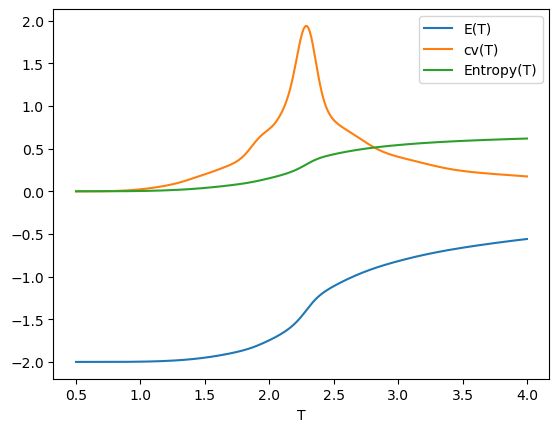

In [14]:
plt.plot(Te, Thm[:,0], label='E(T)')
plt.plot(Te, Thm[:,1], label='cv(T)')
plt.plot(Te, Thm[:,2], label='Entropy(T)')
plt.xlabel('T')
plt.legend(loc='best')

In [15]:
print('Entropy(T=%5.3f)=%8.6f Entropy(T=%5.3f)=%5.3f * log(2)' % (Te[0],Thm[0,2],Te[-1],Thm[-1,2]/np.log(2)))

Entropy(T=0.500)=0.001176 Entropy(T=4.000)=0.894 * log(2)


# Wang-Landau Homework

In [16]:
flatness = 0.9
N = 32
Nitt = int(1e9)

lngs = []
hists = []
for _ in range(5):
    lngE, Hist = WangLandau(Nitt, N, flatness)
    lngs.append(lngE)
    hists.append(Hist)
print('Done')

66359999 histogram is flat 58418.0 64804.6875 f= 1.6487212707001282
78012999 histogram is flat 10254.0 11379.8828125 f= 1.2840254166877414
93060999 histogram is flat 13242.0 14695.3125 f= 1.1331484530668263
110856999 histogram is flat 15653.0 17378.90625 f= 1.0644944589178593
126332999 histogram is flat 13604.0 15113.28125 f= 1.0317434074991028
142336999 histogram is flat 14074.0 15628.90625 f= 1.0157477085866857
156105999 histogram is flat 12105.0 13446.2890625 f= 1.007843097206448
173069999 histogram is flat 14929.0 16566.40625 f= 1.0039138893383475
194785999 histogram is flat 19100.0 21207.03125 f= 1.0019550335910028
213596999 histogram is flat 16534.0 18370.1171875 f= 1.0009770394924165
249253999 histogram is flat 31341.0 34821.2890625 f= 1.0004884004786945
319230999 histogram is flat 61693.0 68336.9140625 f= 1.0002441704297478
370873999 histogram is flat 45402.0 50432.6171875 f= 1.0001220777633837
442882999 histogram is flat 63366.0 70321.2890625 f= 1.0000610370189331
548419999 hi

In [17]:
def normalize_log_density(lngE):
    
    if lngE[-1]>lngE[0]:
        lgC = np.log(4)-lngE[-1]-np.log(1+np.exp(lngE[0]-lngE[-1]))
    else:
        lgC = np.log(4)-lngE[0]-np.log(1+np.exp(lngE[-1]-lngE[0]))
    lngE += lgC
    
    return lngE

In [69]:
# analytically calculated solutions for comparison
g_exact = [2, 2048, 4096, 1057792, 4218880, 371621888, 2191790080, 100903637504, 768629792768, 22748079183872]
lng_exact = np.log(g_exact)
lng_exact

array([ 0.69314718,  7.62461899,  8.31776617, 13.87169427, 15.25508025,
       19.73338747, 21.50798444, 25.33743181, 27.36787528, 30.75550183])

In [19]:
lngE

array([88476.76101685, 88483.58596802, 88484.22171021, ...,
       88483.47161865, 88482.84265137, 88475.99209595])

In [73]:
lngE_runs = np.array([normalize_log_density(lng) for lng in lngs])
num_runs = np.shape(lngE_runs)[0]


mean = np.sum(lngE_runs, axis=0) / num_runs
mean_square = np.sum(lngE_runs**2, axis=0) / num_runs

stdev = np.sqrt((mean_square - mean**2) / (num_runs-1))

In [74]:
stdev[:10]

array([0.10660531, 0.1131321 , 0.11363354, 0.13046757, 0.15730781,
       0.13047044, 0.12656249, 0.11622807, 0.11175356, 0.11558976])

In [75]:
mean[:10]

array([ 0.82830774,  7.80623438,  8.48649561, 14.09763758, 15.47465479,
       19.96988184, 21.7120022 , 25.56603357, 27.55775416, 30.98023645])

The exact solution and our simulations are visually close, but we need to check that this is statistically meaningful. Under the data, I plot the residuals normalized by the exact solutions. They are fairly close. 

Text(0.5, 1.0, 'Exact Solution vs. Simulation')

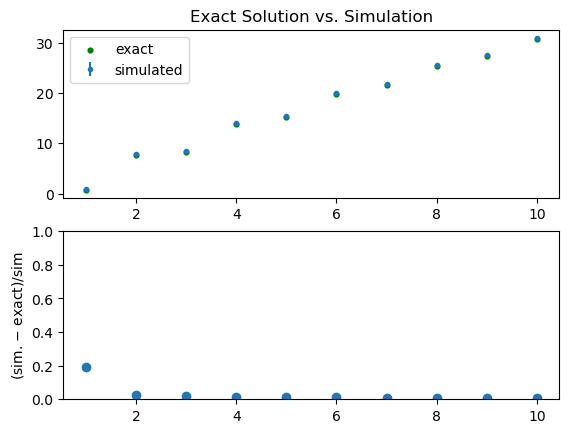

In [76]:
fig, ax = plt.subplots(2, 1)

x_axis = np.arange(1, 11)

ax[0].errorbar(x=x_axis, y=mean[:10], yerr=stdev[:10], fmt='.', label='simulated')
ax[0].scatter(x_axis, lng_exact, s=12, c='g', label='exact')

ax[1].scatter(x_axis, (mean[:10]-lng_exact)/lng_exact)
ax[1].set_ylim([0, 1])
ax[1].set_ylabel(r'(sim. $-$ exact)/sim')

ax[0].legend()

ax[0].set_title('Exact Solution vs. Simulation')

Ideally, the residuals will be less than the standard deviation. This does not appear to be the case. 

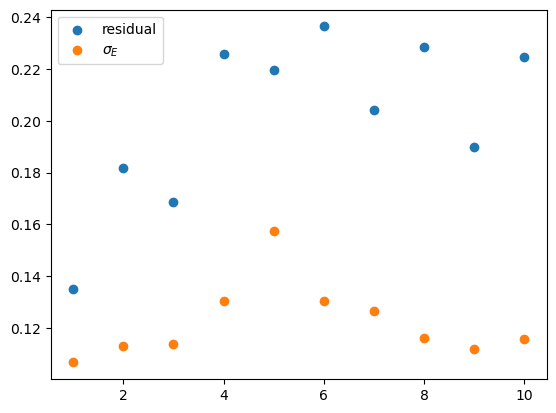

In [77]:
fig, ax = plt.subplots()

ax.scatter(x_axis, (mean[:10]-lng_exact), label='residual')
ax.scatter(x_axis, stdev[:10], label=r'$\sigma_E$')

ax.legend()

We can also quickly calculate a $\chi^2$ value. 

In [79]:
print(f'chi sq: {np.sum((mean[:10]-lng_exact)**2 / lng_exact)}')
print(f'chi sq norm by uncertainty: {np.sum((mean[:10]-lng_exact)**2 / stdev[:10]**2)}')

chi sq: 0.0507366615064642
chi sq norm by uncertainty: 27.756397755866946
